# FFT Net Results

## Overview

First I compare the best FFT net our shallow baseline, then I show some variants of FFT model and preprocessing.

Overall, the best variant was only at ~59% (using handpicked frequency range), still 8% worse than the CSP baseline and 15% worse than the shallow net. Without handpicking the frequency range I can only get to 47.5%.

### Architecture

Input size is (Trials)x22x74x63, Trials x Sensors x Timebins x Freqs. Dropout after pool, batch norm before ELU nonlinearities.

|#Layer|Layer|Units|Filter Size|Stride|Nonlinearity/PoolingMode|
|-|
|1|Conv|25|1x1|1x1|Identity|
|2|Conv|25|3x1|1x1|Identity|
|3|Conv|25|1x63|1x1|ELU|
|3|Pool||3x1|3x1|Max|
|4|Conv|50|3x1|1x1|ELU|
|5|Pool||3x1|3x1|Max|
|6|Conv|100|3x1|1x1|ELU|
|7|Pool||3x1|3x1|Max|
|10|Dense|4|3x1|1x1|Softmax|

## Comparison to Shallow Net

* ~27% worse
* Training accuracy is 99.69%, so no fitting problems on training set

|Shallow Net|FFT Net|Diff|Std|Perm|
|-|
|74.4|47.5|-26.9|7.7|0.002|


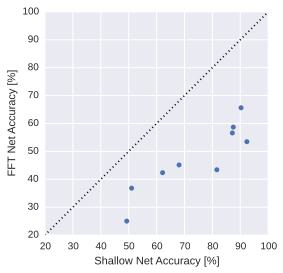

In [44]:
plot_misclass_scatter_with_name(misclasses_baseline, misclasses_spat_time_freq,
             first_name="Shallow Net", second_name='FFT Net')


## Handpicked frequency range

My intuition is that there are too many uninformative frequency bins (>40Hz) which are allowing too much overfitting. So I checked what happens if I handpick the frequency range form 0-40Hz.

* ~9% better



|0-124 Hz|0-40 Hz|Diff|Std|Perm|
|-|
|47.5|56.4|8.9|8.5|0.004|

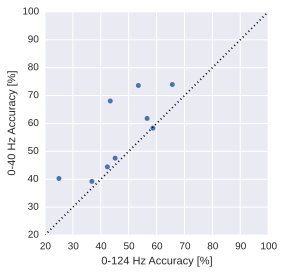

In [60]:
plot_misclass_scatter_with_name(misclasses_spat_time_freq, misclasses_stop_40,
            first_name='0-124 Hz', second_name='0-40 Hz')

However, since we are more interested in end-to-end learning/not handpicking frequencies, I continued more experiments with the full frequency range.

## Pool padding

After running, I realized that I had not used padding when pooling and therefore lost quite some parts of the last feature map. However, with padding it got slightly worse, ~3%

|Without Padding|With Padding|Diff|Std|Perm|
|-|
|47.5|44.3|-3.2|5.1|0.063|

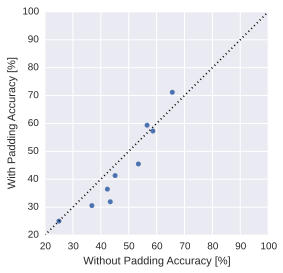

In [50]:
plot_misclass_scatter_with_name(misclasses_spat_time_freq, misclasses_spat_time_freq_pad,
             first_name='Without Padding', second_name='With Padding')

### Linear model

I compare to the model that I used in my master thesis:

Linear classifier made from 3 tensor multiplications, first multiplication with sensor weights, then with (unitsx)frequency weights, then with (unitsx)timebin weights. Implemented as 3 layers, with dropout inbetween.
Also only using 15 timebins in this case (also tried with same amount of timebins as deep net, but that was slightly worse).

* only ~3% worse

|Deep Sensors-Time-Freq|Linear Sensors-Freq-Time|Diff|Std|Perm|
|-|
|47.5|44.1|-3.4|8.1|0.14|


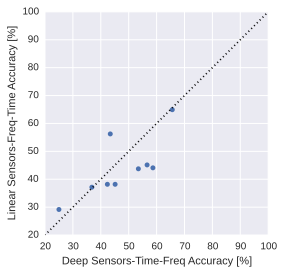

In [74]:
plot_misclass_scatter_with_name(misclasses_spat_time_freq, misclasses_linear,
            first_name='Deep Sensors-Time-Freq', second_name='Linear Sensors-Freq-Time')

### Differently split first layer

The model described convolves in the order: sensors - time - frequencies.

I also tried:
* altogether in one layer
* sensors - frequencies - time
* frequencies - sensors - time
* frequencies - time - sensors

They are all quite similar in performance, differences may be random/noise.

#### Combined First Convolution

|Sensors-Time-Freq|Combined|Diff|Std|Perm|
|-|
|47.5|44.7|-2.8|6.3|0.13|


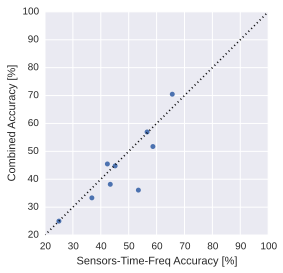

In [61]:

plot_misclass_scatter_with_name(misclasses_spat_time_freq, misclasses_combined_conv,
            first_name='Sensors-Time-Freq', second_name='Combined')

#### Sensors-Freq-Time

|Sensors-Time-Freq|Sensors-Freq-Time|Diff|Std|Perm|
|-|
|47.5|43.6|-3.8|4.6|0.015625|

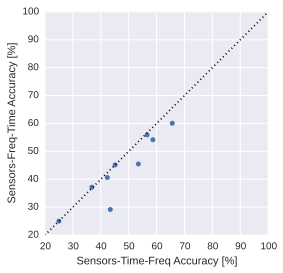

In [63]:
plot_misclass_scatter_with_name(misclasses_spat_time_freq, misclasses_spat_freq_time,
            first_name='Sensors-Time-Freq', second_name='Sensors-Freq-Time')

#### Freq-Sensors-Time

|Sensors-Time-Freq|Freq-Sensors-Time|Diff|Std|Perm|
|-|
|47.5|46.3|-1.1|5.1|0.27|

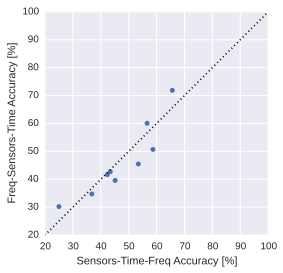

In [66]:
plot_misclass_scatter_with_name(misclasses_spat_time_freq, misclasses_freq_spat_time,
            first_name='Sensors-Time-Freq', second_name='Freq-Sensors-Time')


#### Freq-Time-Sensor


|Sensors-Time-Freq|Freq-Time-Sensors|Diff|Std|Perm|
|-|
|47.5|46.3|-1.1|6.9|0.35|

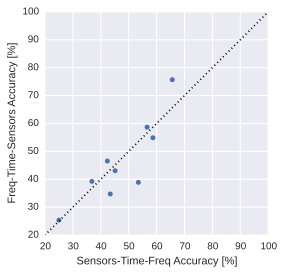

In [67]:
plot_misclass_scatter_with_name(misclasses_spat_time_freq, misclasses_freq_time_spat,
            first_name='Sensors-Time-Freq', second_name='Freq-Time-Sensors')

## Squaring Amplitude

Finally, I checked whether including the phase or squaring the amplitudes would help. **This is on the handpicked frequency range 0-40**. Including the phase actually was worse by ~12% (more overfitting possible I guess), but squaring helped a little bit.

* 2.5% better

|Amplitude|Squared Amplitude|Diff|Std|Perm|
|-|
|56.4|58.9|2.5|3.5|0.049|


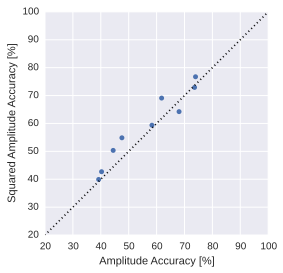

In [41]:
plot_misclass_scatter_with_name(misclasses_stop_40,misclasses_stop_40_squared_amp,
            first_name='Amplitude', second_name='Squared Amplitude')

|Baseline|Squared Amplitude|Diff|Std|Perm|
|-|
|47.5|58.9|11.5|6.6|0.001953|


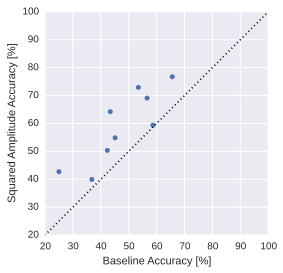

In [63]:
show_results(misclasses_spat_time_freq, misclasses_stop_40_squared_amp,
            first_name='Baseline', second_name='Squared Amplitude')

# Code

In [1]:
%%capture
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

import matplotlib.lines as mlines
import seaborn
matplotlib.rcParams['figure.figsize'] = (12.0, 3.0)
matplotlib.rcParams['font.size'] = 7
seaborn.set_style('darkgrid')

from braindecode.scripts.print_results import ResultPrinter
from braindecode.csp.print_results import CSPResultPrinter
import logging
log = logging.getLogger()
log.setLevel("DEBUG")

In [2]:
from braindecode.results.results import (load_dataset_grouped_result_objects_for,
                                         get_final_misclasses,
                                         sort_results_by_filename)
from braindecode.analysis.stats import perm_mean_diffs
def extract_single_group_result(folder, params):
    res = load_dataset_grouped_result_objects_for(folder, params=params)
    assert len(res) == 1, "Assuming just one group result here"
    res = res[0]
    # sort by filename!!
    res = sort_results_by_filename(res)
    return res

from braindecode.analysis.plot_util import show_misclass_scatter_plot
def show_results(first_misclasses, second_misclasses, first_name='Baseline (log(mean(square)))',
                 second_name=''):
   
    plot_misclass_scatter_with_name(first_misclasses, second_misclasses,
                                    first_name, second_name)
    diffs = perm_mean_diffs(first_misclasses,second_misclasses)

    actual_diff = np.mean(first_misclasses - second_misclasses)

    # one sided without checking direction before
    perm_p_val = (np.sum(abs(diffs) >= abs(actual_diff)) / 
            (float(len(diffs) * 2.0)))
    print("|{:s}|{:s}|{:s}|{:s}|{:s}|".format(first_name, second_name, "Diff", "Std", "Perm"))
    print("|-|")
    print("|{:.1f}|{:.1f}|{:.1f}|{:.1f}|{:f}|".format(100 * (1-np.mean(first_misclasses)), 
                                               100 * (1-np.mean(second_misclasses)),
                                               100 * actual_diff, # - to get accuracy from misclass
                                               100 * np.std(second_misclasses - first_misclasses),
                                                perm_p_val))
    
def plot_misclass_scatter_with_name(first_misclasses, second_misclasses, first_name='Baseline (log(mean(square)))',
                 second_name=''):
    show_misclass_scatter_plot(first_misclasses, second_misclasses)
    plt.xlabel('{:s} Accuracy [%]'.format(first_name))
    plt.ylabel('{:s} Accuracy [%]'.format(second_name))

## Shallow Net

In [3]:
# Shallow net with log(mean) pooling and square
ResultPrinter('data/models/paper/bci-competition/cnt/shallow/').print_results(individual_datasets=False,
     params=dict(resample_fs=250, low_cut_off_hz="null",
                 first_nonlin='$square', pool_mode='average_exc_pad',
                 cnt_preprocessors='$resample_highpass_standardize',
                 loss_expression='$tied_neighbours',
                 post_pool_nonlin='$safe_log', drop_p=None,
                 layers='$cnt_shallow_square'
                ))

Printing results in data/models/paper/bci-competition/cnt/shallow/:


Dataset-Averaged Results:

Terminal Table

id  files  time     std      test_sample  std     test    std     train_sample  std    train   std    valid_sample  std    valid   std    
0   9      0:12:03  0:02:38  68.95%       15.06%  74.38%  16.08%  95.35%        2.41%  99.00%  0.90%  91.71%        4.20%  95.90%  4.03%  

Markdown Table

|id|files|time|std|test_sample|std|test|std|train_sample|std|train|std|valid_sample|std|valid|std|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|9|0:12:03|0:02:38|68.95%|15.06%|74.38%|16.08%|95.35%|2.41%|99.00%|0.90%|91.71%|4.20%|95.90%|4.03%|


In [4]:
results_baseline = extract_single_group_result('data/models/paper/bci-competition/cnt/shallow/',
             dict(resample_fs=250, low_cut_off_hz="null",
                 first_nonlin='$square', pool_mode='average_exc_pad',
                 cnt_preprocessors='$resample_highpass_standardize',
                 loss_expression='$tied_neighbours',
                 post_pool_nonlin='$safe_log', drop_p=None,
                 layers='$cnt_shallow_square'
                ))
misclasses_baseline = get_final_misclasses(results_baseline)

### Nonlinearities

#### vs best FFT

In [5]:
ResultPrinter('data/models/paper/bci-competition/epo/deep-fft/').print_results(individual_datasets=False,
  shorten=False,
  params=dict(layers='$deep_fft_net_spat_time_freq'))

Printing results in data/models/paper/bci-competition/epo/deep-fft/:


Dataset-Averaged Results:

Terminal Table

id  files  frequency_end  tag       frequency_start  final_pool_time_stride  final_pool_time_length  time     std      test    std     train    std    valid    std     
0   9      -              repl      -                -                       -                       0:04:51  0:01:16  47.45%  11.74%  99.69%   0.76%  98.81%   2.38%   
1   9      -              pool_pad  -                2                       2                       0:04:54  0:01:08  44.29%  14.55%  96.88%   8.84%  95.24%   13.47%  
2   9      40             pool_pad  4                -                       -                       0:02:05  0:00:13  55.02%  13.67%  99.96%   0.11%  100.00%  0.00%   
3   9      40             pool_pad  0                -                       -                       0:02:22  0:00:30  56.37%  13.12%  99.92%   0.22%  99.21%   2.24%   
4   4      36             pool_pad  0    

|Baseline (log(mean(square)))|FFT|Diff|Std|Perm|
|-|
|74.4|47.5|-26.9|7.7|0.001953|


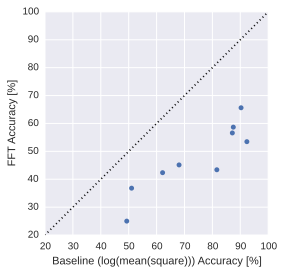

In [6]:
results_spat_time_freq = extract_single_group_result('data/models/paper/bci-competition/epo/deep-fft/',
                 params=dict(layers='$deep_fft_net_spat_time_freq', tag="repl"))

misclasses_spat_time_freq = get_final_misclasses(results_spat_time_freq)

show_results(misclasses_baseline, misclasses_spat_time_freq, second_name='FFT')

### Pool padding

|Without Padding|With Padding|Diff|Std|Perm|
|-|
|47.5|44.3|-3.2|5.1|0.062500|


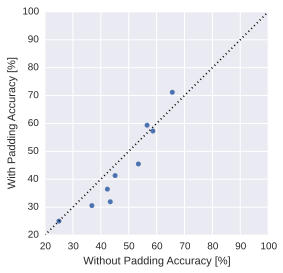

In [9]:
results_spat_time_freq_pad = extract_single_group_result('data/models/paper/bci-competition/epo/deep-fft/',
                 params=dict(layers='$deep_fft_net_spat_time_freq', tag="pool_pad",
                            frequency_start=None))

misclasses_spat_time_freq_pad = get_final_misclasses(results_spat_time_freq_pad)

show_results(misclasses_spat_time_freq, misclasses_spat_time_freq_pad,
             first_name='Without Padding', second_name='With Padding')

## Altogether

In [10]:
ResultPrinter('data/models/paper/bci-competition/epo/deep-fft/').print_results(individual_datasets=False,
  shorten=False,
  params=dict(layers='$deep_fft_net_combined'))

Printing results in data/models/paper/bci-competition/epo/deep-fft/:


Dataset-Averaged Results:

Terminal Table

id  files  time     std      test    std     train   std    valid   std    
0   9      0:05:56  0:01:54  44.68%  12.90%  99.46%  1.53%  98.41%  4.49%  

Markdown Table

|id|files|time|std|test|std|train|std|valid|std|
|-|-|-|-|-|-|-|-|-|-|
|0|9|0:05:56|0:01:54|44.68%|12.90%|99.46%|1.53%|98.41%|4.49%|


|Sensors-Time-Freq|Combined|Diff|Std|Perm|
|-|
|47.5|44.7|-2.8|6.3|0.125000|


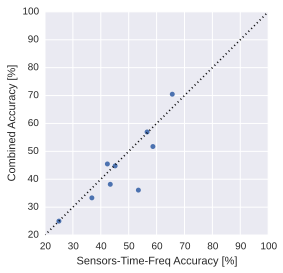

In [11]:
results_combined_conv = extract_single_group_result('data/models/paper/bci-competition/epo/deep-fft/',
                 params=dict(layers='$deep_fft_net_combined', tag="repl"))

misclasses_combined_conv  = get_final_misclasses(results_combined_conv)

show_results(misclasses_spat_time_freq, misclasses_combined_conv,
            first_name='Sensors-Time-Freq', second_name='Combined')

### Sensors-Freq-Time

In [12]:
ResultPrinter('data/models/paper/bci-competition/epo/deep-fft/').print_results(individual_datasets=False,
  shorten=False,
  params=dict(layers='$deep_fft_net_spat_freq_time'))

Printing results in data/models/paper/bci-competition/epo/deep-fft/:


Dataset-Averaged Results:

Terminal Table

id  files  time     std      test    std     train   std    valid    std    
0   9      0:05:46  0:01:38  43.63%  11.28%  99.96%  0.11%  100.00%  0.00%  

Markdown Table

|id|files|time|std|test|std|train|std|valid|std|
|-|-|-|-|-|-|-|-|-|-|
|0|9|0:05:46|0:01:38|43.63%|11.28%|99.96%|0.11%|100.00%|0.00%|


|Sensors-Time-Freq|Sensors-Freq-Time|Diff|Std|Perm|
|-|
|47.5|43.6|-3.8|4.6|0.015625|


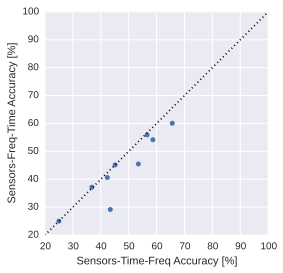

In [13]:
results_spat_freq_time = extract_single_group_result('data/models/paper/bci-competition/epo/deep-fft/',
                 params=dict(layers='$deep_fft_net_spat_freq_time', tag="repl"))

misclasses_spat_freq_time  = get_final_misclasses(results_spat_freq_time)

show_results(misclasses_spat_time_freq, misclasses_spat_freq_time,
            first_name='Sensors-Time-Freq', second_name='Sensors-Freq-Time')

### Freq Sensors Time

|Sensors-Time-Freq|Freq-Sensors-Time|Diff|Std|Perm|
|-|
|47.5|46.3|-1.1|5.1|0.265625|


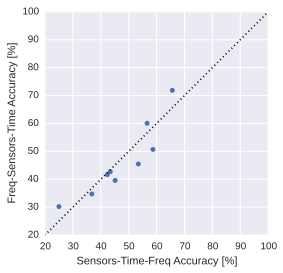

In [14]:
results_freq_spat_time = extract_single_group_result('data/models/paper/bci-competition/epo/deep-fft/',
                 params=dict(layers='$deep_fft_net_freq_spat_time', tag="repl"))

misclasses_freq_spat_time  = get_final_misclasses(results_freq_spat_time)

show_results(misclasses_spat_time_freq, misclasses_freq_spat_time,
            first_name='Sensors-Time-Freq', second_name='Freq-Sensors-Time')

### Freq Time Sensors

|Sensors-Time-Freq|Freq-Time-Sensors|Diff|Std|Perm|
|-|
|47.5|46.3|-1.1|6.9|0.349609|


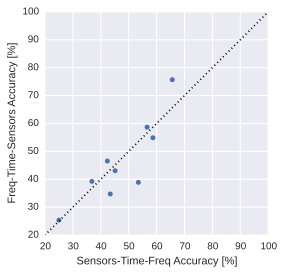

In [15]:
results_freq_time_spat = extract_single_group_result('data/models/paper/bci-competition/epo/deep-fft/',
                 params=dict(layers='$deep_fft_net_freq_time_spat', tag="repl"))

misclasses_freq_time_spat  = get_final_misclasses(results_freq_time_spat)

show_results(misclasses_spat_time_freq, misclasses_freq_time_spat,
            first_name='Sensors-Time-Freq', second_name='Freq-Time-Sensors')

### Linear model

In [17]:
ResultPrinter('data/models/paper/bci-competition/epo/deep-fft/').print_results(individual_datasets=False,
  shorten=False,
  params=dict(layers='$seperated_linear', preprocessor='null', fft_window_stride=62, drop_in_prob=0.,
             frequency_start=None))

Printing results in data/models/paper/bci-competition/epo/deep-fft/:


Dataset-Averaged Results:

Terminal Table

id  files  time     std      test    std     train   std    valid   std     
0   9      0:01:41  0:00:51  44.10%  10.13%  95.87%  5.94%  88.49%  14.94%  

Markdown Table

|id|files|time|std|test|std|train|std|valid|std|
|-|-|-|-|-|-|-|-|-|-|
|0|9|0:01:41|0:00:51|44.10%|10.13%|95.87%|5.94%|88.49%|14.94%|


|Deep Sensors-Time-Freq|Linear Sensors-Freq-Time|Diff|Std|Perm|
|-|
|47.5|44.1|-3.4|8.1|0.138672|


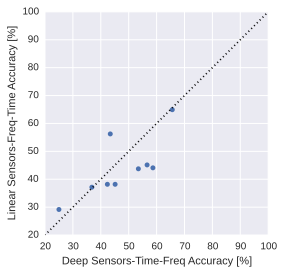

In [18]:
results_linear = extract_single_group_result('data/models/paper/bci-competition/epo/deep-fft/',
    params=dict(layers='$seperated_linear', preprocessor='null', fft_window_stride=62, drop_in_prob=0.,
               frequency_start=None))

misclasses_linear  = get_final_misclasses(results_linear)

show_results(misclasses_spat_time_freq, misclasses_linear,
            first_name='Deep Sensors-Time-Freq', second_name='Linear Sensors-Freq-Time')

## Handpicked frequencies

In [34]:
ResultPrinter('data/models/paper/bci-competition/epo/deep-fft/').print_results(individual_datasets=False,
  shorten=False,
  params=dict(preprocessor='null', fft_window_stride=12, drop_in_prob=0.,
             frequency_start=0, frequency_end=40,
             include_phase=False, square_amplitude=False))

Printing results in data/models/paper/bci-competition/epo/deep-fft/:


Dataset-Averaged Results:

Terminal Table

id  files  time     std      test    std     train   std    valid   std    
0   9      0:02:22  0:00:30  56.37%  13.12%  99.92%  0.22%  99.21%  2.24%  

Markdown Table

|id|files|time|std|test|std|train|std|valid|std|
|-|-|-|-|-|-|-|-|-|-|
|0|9|0:02:22|0:00:30|56.37%|13.12%|99.92%|0.22%|99.21%|2.24%|


|0-124 Hz|0-40 Hz|Diff|Std|Perm|
|-|
|47.5|56.4|8.9|8.5|0.003906|


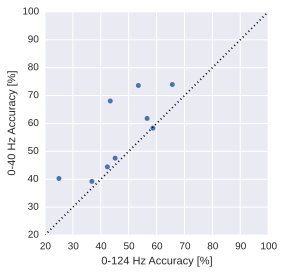

In [30]:
results_stop_40 = extract_single_group_result('data/models/paper/bci-competition/epo/deep-fft/',
    params=dict(preprocessor='null', fft_window_stride=12, drop_in_prob=0.,
             frequency_start=0, frequency_end=40,
             include_phase=False, square_amplitude=False))

misclasses_stop_40  = get_final_misclasses(results_stop_40)

show_results(misclasses_spat_time_freq, misclasses_stop_40,
            first_name='0-124 Hz', second_name='0-40 Hz')

## Square amplitude

In [38]:
ResultPrinter('data/models/paper/bci-competition/epo/deep-fft/').print_results(individual_datasets=False,
  shorten=False,
  params=dict(preprocessor='null', fft_window_stride=12, drop_in_prob=0.,
             frequency_start=0, frequency_end=40))

Printing results in data/models/paper/bci-competition/epo/deep-fft/:


Dataset-Averaged Results:

Terminal Table

id  files  include_phase  square_amplitude  time     std      test    std     train    std     valid    std     
0   9      0              0                 0:02:22  0:00:30  56.37%  13.12%  99.92%   0.22%   99.21%   2.24%   
1   9      1              1                 0:03:15  0:00:44  53.47%  10.66%  100.00%  0.00%   100.00%  0.00%   
2   9      0              1                 0:02:36  0:00:34  58.91%  12.29%  100.00%  0.00%   100.00%  0.00%   
3   9      1              0                 0:03:18  0:01:16  44.37%  13.05%  88.58%   17.18%  84.92%   21.94%  

Markdown Table

|id|files|include_phase|square_amplitude|time|std|test|std|train|std|valid|std|
|-|-|-|-|-|-|-|-|-|-|-|-|
|0|9|False|False|0:02:22|0:00:30|56.37%|13.12%|99.92%|0.22%|99.21%|2.24%|
|1|9|True|True|0:03:15|0:00:44|53.47%|10.66%|100.00%|0.00%|100.00%|0.00%|
|2|9|False|True|0:02:36|0:00:34|58.91%|12.29%|100.

|Amplitude|Squared Amplitude|Diff|Std|Perm|
|-|
|56.4|58.9|2.5|3.5|0.048828|


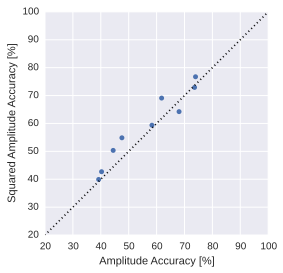

In [39]:
results_stop_40_squared_amp = extract_single_group_result('data/models/paper/bci-competition/epo/deep-fft/',
    params=dict(preprocessor='null', fft_window_stride=12, drop_in_prob=0.,
             frequency_start=0, frequency_end=40,
             include_phase=False, square_amplitude=True))

misclasses_stop_40_squared_amp  = get_final_misclasses(results_stop_40_squared_amp)

show_results(misclasses_stop_40,misclasses_stop_40_squared_amp,
            first_name='Amplitude', second_name='Squared Amplitude')

In [42]:
results_phase = extract_single_group_result('data/models/paper/bci-competition/epo/deep-fft/',
    params=dict(preprocessor='null', fft_window_stride=12, drop_in_prob=0.,
             frequency_start=0, frequency_end=40,
             include_phase=True, square_amplitude=False))

In [49]:
from braindecode.results.results import get_all_misclasses
from braindecode.analysis.plot_util import plot_mean_std_misclasses_over_time, plot_misclasses_over_time

In [45]:
all_misclasses_phase = get_all_misclasses(results_phase)

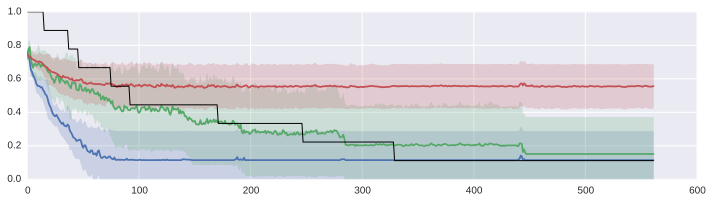

In [47]:
plot_mean_std_misclasses_over_time(all_misclasses_phase)

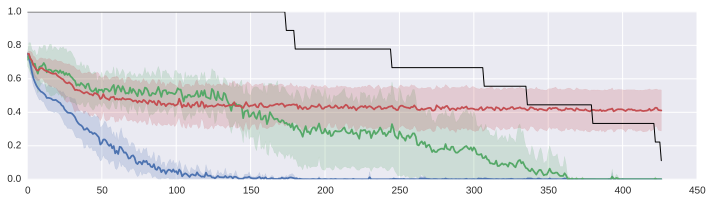

In [55]:
all_misclasses_square_amp = get_all_misclasses(results_stop_40_squared_amp)
plot_mean_std_misclasses_over_time(all_misclasses_square_amp)

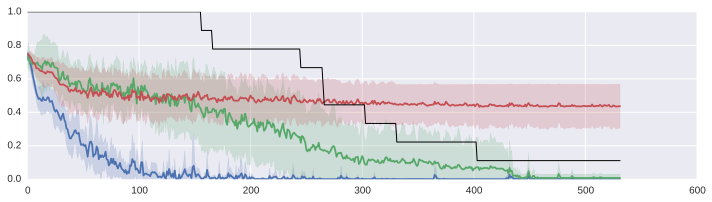

In [56]:
all_misclasses_stop_40 = get_all_misclasses(results_stop_40)
plot_mean_std_misclasses_over_time(all_misclasses_stop_40)